# Programming for Data Science Assessment 

# The Ashes Series 2002 to 2025 (Cricket)
### What I aim to investigate within the dataset:

What are the results of each match and series

Is there a such thing as a home advantage?

Who are the top bowlers and batters from 2002 to 2025?

Is there any head to head rivalries?

Has Bazball had an effect on the ashes series? 




## Loading in Datasets

In [2]:
# Importing pandas 
import pandas as pd 

# Importing glob and os 
# These two packages allow access to files and directories 
# creating lists of paths that can parse to extract file
# and directory names 
import glob 
import os 

# Loading in Data
file_pattern = "*.csv"
all_files = glob.glob(file_pattern)

# Loop reading in all files in same folder 
dfs = []
for filename in all_files:
    df = pd.read_csv(filename)
    df['match_filename'] = os.path.basename(filename)
    dfs.append(df)

# Merging all files together 
full_data = pd.concat(dfs, axis = 0, ignore_index = True)

From the Cricsheet website I have used a loop to read in 59 .csv files, each containing ball by ball data, from 2002 to 2025. This includes 13 Ashes test series. Each series contains 5 test matches, however, data wasn't available for  the first 3 matches of the 2002/03 series and last 3 matches of the 2005 series. At first I didnt have any matches from 2005 but after emailing the person in change of the website he provided 2 of the matches for me. The matches which are missing aren't available since they have to don't have the data and to get it, have to listen to commentary radio from 2005 to get ball by ball data. 

Before writing a loop I read in all the files individually. This was time consuming and not an effective way to read in so many files. I therefore quickly made the decision to use a loop instead.

In [3]:
print(full_data)

        match_id   season  start_date                                   venue  \
0         592397  2013/14  2013-11-21  Brisbane Cricket Ground, Woolloongabba   
1         592397  2013/14  2013-11-21  Brisbane Cricket Ground, Woolloongabba   
2         592397  2013/14  2013-11-21  Brisbane Cricket Ground, Woolloongabba   
3         592397  2013/14  2013-11-21  Brisbane Cricket Ground, Woolloongabba   
4         592397  2013/14  2013-11-21  Brisbane Cricket Ground, Woolloongabba   
...          ...      ...         ...                                     ...   
113164    592400  2013/14  2013-12-26                Melbourne Cricket Ground   
113165    592400  2013/14  2013-12-26                Melbourne Cricket Ground   
113166    592400  2013/14  2013-12-26                Melbourne Cricket Ground   
113167    592400  2013/14  2013-12-26                Melbourne Cricket Ground   
113168    592400  2013/14  2013-12-26                Melbourne Cricket Ground   

        innings  ball batti

## Manipulating and cleaning data

In [4]:
# Creating new columns in dataset
# Converting to datetime
full_data['start_date'] = pd.to_datetime(full_data['start_date'])
full_data = full_data.sort_values(by = ['start_date', 'innings', 'ball'])
full_data =  full_data.reset_index(drop = True)

# New column for year 
full_data['year'] = full_data['start_date'].dt.year

# New column of total runs (runs off bat + extras)
full_data['total_runs'] = full_data['runs_off_bat'] + full_data['extras']

# Cumulatively summing runs off bat for each innings of a match 
full_data['Runs_added_up'] = full_data.groupby(['match_id','innings'])['runs_off_bat'].cumsum()

# If a wicket has happened its classed as 1 if not 0
# Excludes run outs because they dont count towards the bowlers statistics
wickets = ['bowled', 'caught', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']
full_data['wicket'] = full_data['wicket_type'].apply(lambda x: 1 if x in wickets else 0)

# Removing NaN from different columns and replacing with either 0 or none
full_data['wides'] = full_data['wides'].fillna('0')
full_data['noballs'] = full_data['noballs'].fillna('0')
full_data['byes'] = full_data['byes'].fillna('0')
full_data['legbyes'] = full_data['legbyes'].fillna('0')
full_data['penalty'] = full_data['penalty'].fillna('0')
full_data['wicket_type'] = full_data['wicket_type'].fillna('none')
full_data['player_dismissed'] = full_data['player_dismissed'].fillna('none')
full_data['other_wicket_type'] = full_data['other_wicket_type'].fillna('none')
full_data['other_player_dismissed'] = full_data['other_player_dismissed'].fillna('none')

# Splitting ball in over number and ball number 
full_data['over_num'] = full_data['ball'].astype(str).str.split('.').str[0].astype(float)
full_data['ball_num'] = full_data['ball'].astype(str).str.split('.').str[1].astype(float)

# Determing amount of runs each batter got in each innings (there are 4 innings in a test match)
full_data['player_match_runs'] = full_data.groupby(['match_id', 'innings', 'striker'])['runs_off_bat'].transform('sum')

# Determining amount of runs of each innings 
full_data['run_totals'] = full_data.groupby(['match_id', 'innings'])['total_runs'].transform('sum')

# Determining amount of runs scored by each team in entire game  
full_data['total_scored'] = full_data.groupby(['match_id','batting_team'])['total_runs'].transform('sum')

# Adding match_label colummn 
full_data['match_label'] = full_data['year'].astype(str) + "(ID: " + full_data['match_id'].astype(str) + ")"

print(full_data)

        match_id   season start_date                     venue  innings  ball  \
0          64012  2002/03 2002-12-26  Melbourne Cricket Ground        1   0.1   
1          64012  2002/03 2002-12-26  Melbourne Cricket Ground        1   0.2   
2          64012  2002/03 2002-12-26  Melbourne Cricket Ground        1   0.3   
3          64012  2002/03 2002-12-26  Melbourne Cricket Ground        1   0.4   
4          64012  2002/03 2002-12-26  Melbourne Cricket Ground        1   0.5   
...          ...      ...        ...                       ...      ...   ...   
113164   1455615  2025/26 2026-01-04     Sydney Cricket Ground        4  30.4   
113165   1455615  2025/26 2026-01-04     Sydney Cricket Ground        4  30.5   
113166   1455615  2025/26 2026-01-04     Sydney Cricket Ground        4  30.6   
113167   1455615  2025/26 2026-01-04     Sydney Cricket Ground        4  31.1   
113168   1455615  2025/26 2026-01-04     Sydney Cricket Ground        4  31.2   

       batting_team bowling

## Bowling statistics: Who are the top bowlers?

### Scatter plot showing the top 15 wicket taking bowlers: strike rate vs bowling average

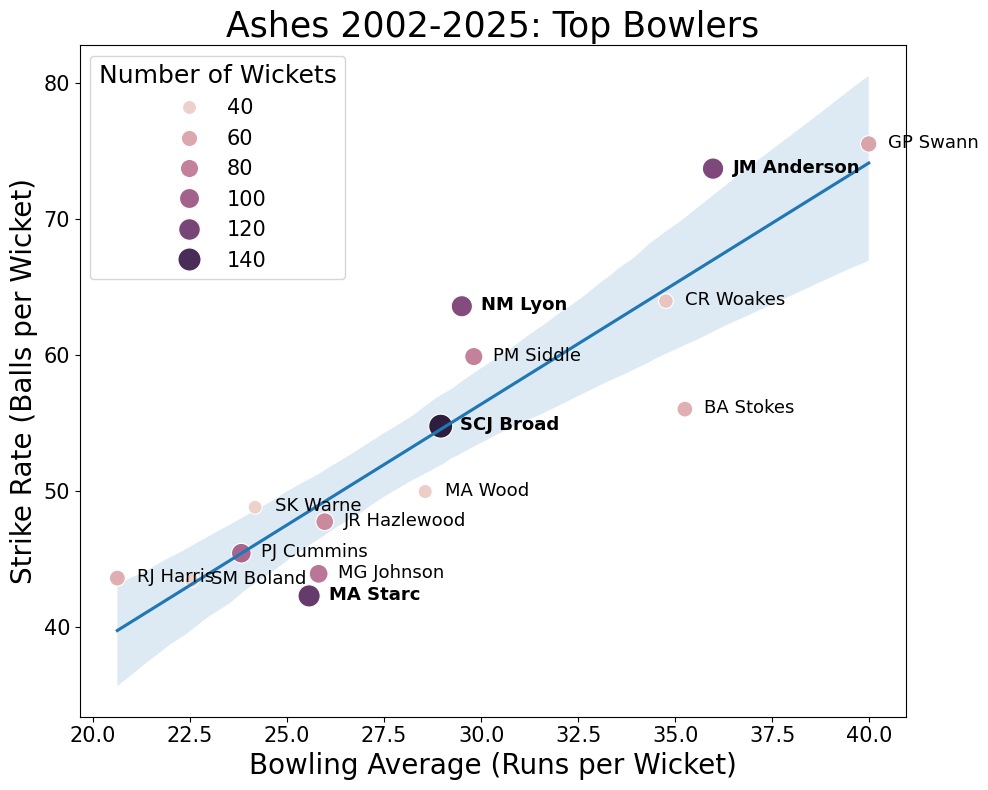

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Creating new column in full_data showing the total runs scored against a specific bowler
wides = pd.to_numeric(full_data['wides'], errors='coerce').fillna(0)
noballs = pd.to_numeric(full_data['noballs'], errors='coerce').fillna(0)
full_data['bowler_runs'] = wides + noballs + full_data['runs_off_bat']

# Creating new dataframe for best bowlers by grouping bowlers and summing wickets, runs and counting number of balls 
bowler_stats = full_data.groupby(['bowler', 'bowling_team']).agg({'wicket':'sum',
                                                'bowler_runs':'sum',
                                                'ball': 'count'}).reset_index()
# Selecting 15 bowlers with the most wickets
best_bowlers = bowler_stats.nlargest(15, 'wicket')

# Making new columns for bowling averages, strike rates and economy 
best_bowlers['bowling_avg'] = best_bowlers['bowler_runs'] / best_bowlers['wicket']
best_bowlers['strike_rate'] = best_bowlers['ball'] / best_bowlers['wicket']
best_bowlers['economy'] = (best_bowlers['bowler_runs']/best_bowlers['ball']) * 6

plt.figure(figsize = (10,8))

# Creating regplot (line of best fit)
sns.regplot(data = best_bowlers,
            x = 'bowling_avg',
            y = 'strike_rate',
            scatter = False)

# Creating Scatterplot 
sns.scatterplot(data = best_bowlers,
                x = 'bowling_avg',
                y = 'strike_rate',
                size = 'wicket',
                hue = 'wicket',
                sizes = (100,300))

# Lower is better for both strike rate and bowling average 
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()

# Adding bowlers names to points
for i in range(best_bowlers.shape[0]):
    high = best_bowlers.wicket.iloc[i] > 100
    weight = 'bold' if high else 'normal'
    size = 13 if high else 13
    
    plt.text(x = best_bowlers.bowling_avg.iloc[i] + 0.5,
             y = best_bowlers.strike_rate.iloc[i] - 0.3,
             s = best_bowlers.bowler.iloc[i],
             fontsize = size, fontweight = weight)

# Adding title, axis titles and legend
plt.title('Ashes 2002-2025: Top Bowlers', fontsize = 25)
plt.xlabel('Bowling Average (Runs per Wicket)', fontsize = 20)
plt.ylabel('Strike Rate (Balls per Wicket)', fontsize = 20)
plt.legend(title = "Number of Wickets", 
           loc = 'upper left', fontsize = 15, title_fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# Plotting graph
#plt.grid(True, linestyle = '--', alpha = 0.4)
plt.tight_layout()
plt.show()

### Pearson correlation between bowling average and strike rate

In [6]:
from scipy.stats import pearsonr
# Correlation between bowling avg and strike rate
# Convert dataframe into series
l1 = best_bowlers['bowling_avg']
l2 = best_bowlers['strike_rate']

# Applying the pearsonr()
corr, _ = pearsonr(l1, l2)
print('Pearsons correlation: %.3f' % corr)
print('Strong positive linear correlation!')

Pearsons correlation: 0.899
Strong positive linear correlation!


From the scatter plot and the pearson correlation you can see there is a strong positive linear correlation between bowling average and strike rate for the top 15 bowlers. The lower the bowling average and strike rate and the higher the number of wickets the better the bowler. From the scatter plot you can see Stuart Broad (English) has the most wickets. The best bowler on the plot I would argue is Mitchell Starc (Australian). He has both a low bowling average and strike rate (lower then Broad) and still a high number of wickets. 

### Bar chart of the most wickets taken between 2002 and 2025 by bowlers, excluding runouts 

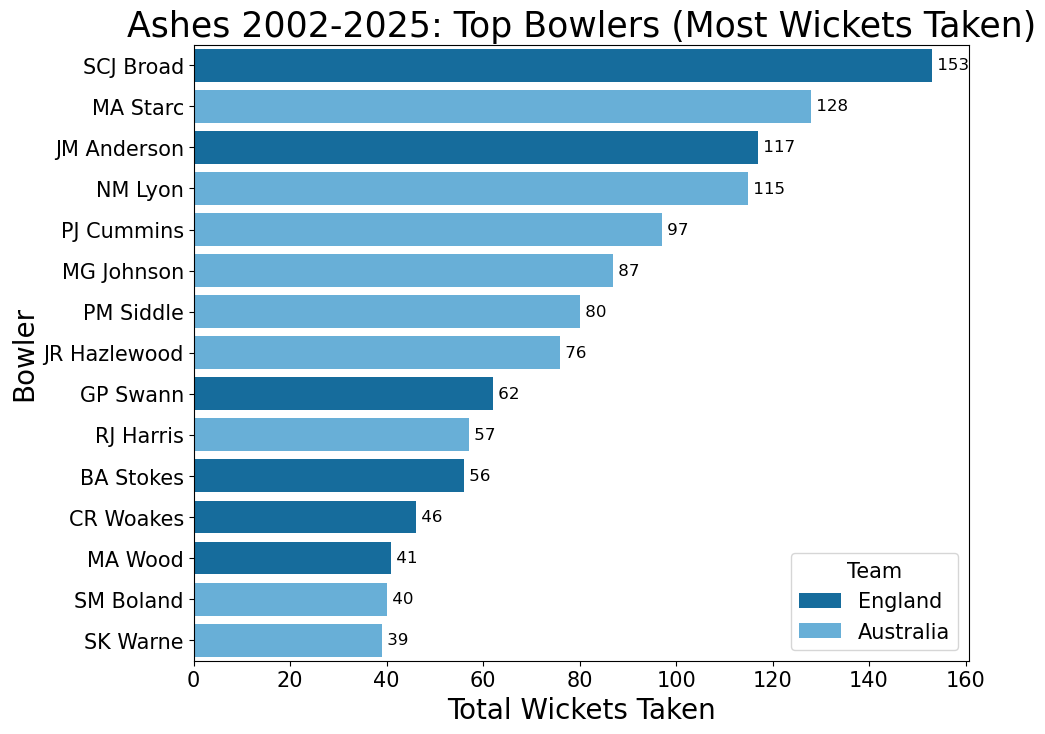

In [7]:
# Adding colours
custom_palette = sns.color_palette(['#0072B2', '#56B4E9'])

# Creating barplot of best batters 
plt.figure(figsize = (10,8))
sns.barplot(data = best_bowlers, 
            x = 'wicket', 
            y = 'bowler',
            hue = 'bowling_team',
            palette = custom_palette)

# Adding number of wickets on the end of each bar 
for index, value in enumerate(best_bowlers.wicket):
    plt.text(value, index, f' {int(value)}', va = 'center', fontsize = 12)

# Plotting graph 
plt.title('Ashes 2002-2025: Top Bowlers (Most Wickets Taken)', fontsize = 25)   
plt.xlabel('Total Wickets Taken', fontsize = 20)
plt.ylabel('Bowler', fontsize = 20)
plt.legend(title = "Team", loc = 'lower right', title_fontsize = 15, fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()


Bar chart showing the top wickets taken from all matches between 2002-2025, coloured by team of player. Stuart Broad has the most wickets and Shane Warne has the least out of the top 15. Shane Warne however has the most ashes wickets of all time with an astonishing 190 wickets. Because the 2005 dataset is incomplete Warne is missing out on a lot of wickets. In the 2005 series he took 40 wickets!

### Heatmap showing number of dismissals by a bowler in each of the series 

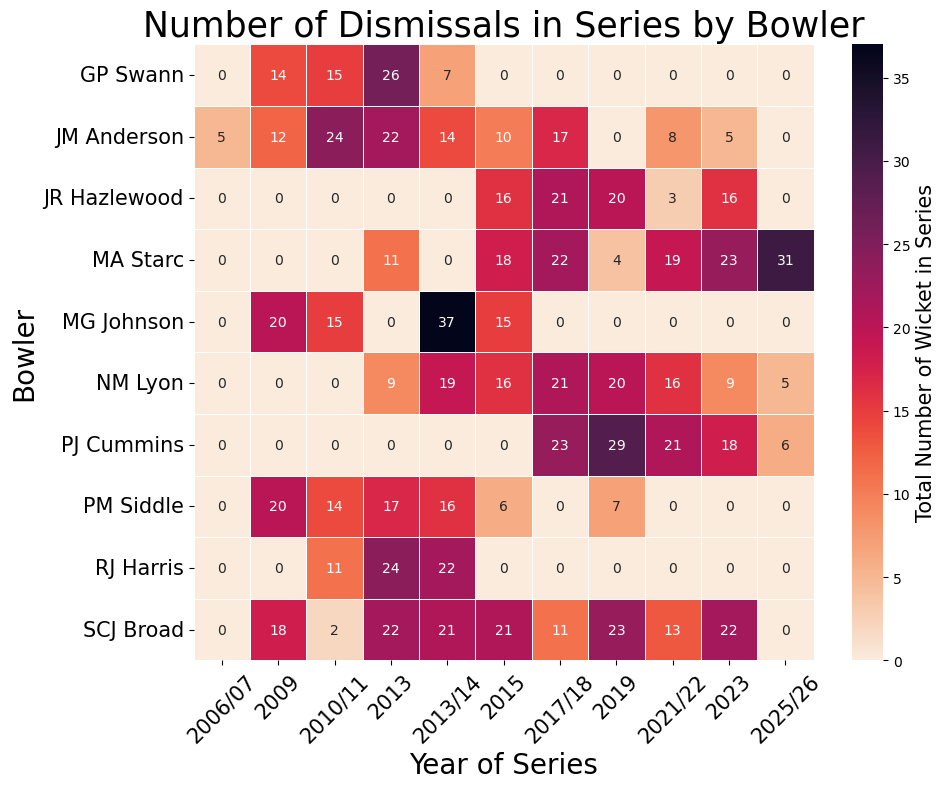

In [8]:
# Creating heatmap to show the top batters in each series 
# Slight issue in the fact series can spand over two different years- solved by creating seasons 
top_10_bowlers = full_data.groupby('bowler')['wicket'].sum().nlargest(10).index
full_data['season'] = full_data['season'].astype(str).str.strip()

heatmap_bowler = full_data[full_data['bowler'].isin(top_10_bowlers)].pivot_table(index = 'bowler',
                                                                                 columns = 'season',
                                                                                 values = 'wicket',
                                                                                 aggfunc = 'sum').fillna(0)
# Plotting heatmap
plt.figure(figsize = (10,8))
ax = sns.heatmap(heatmap_bowler,
            annot = True,
            fmt = '.0f',
            cmap = 'rocket_r',
            linewidths = .5,
            cbar_kws = {'label': 'Total Number of Wicket in Series'})


plt.title('Number of Dismissals in Series by Bowler', fontsize = 25)
plt.ylabel('Bowler', fontsize = 20)
plt.xlabel('Year of Series', fontsize = 20)
plt.xticks(rotation = 45)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.figure.axes[-1].yaxis.label.set_size(15)
plt.show()

Heatmap shows the dominant bowlers in each series from australia and england. The heatmap however is missing the first two series since its taking the top 10 wicket takers and they didnt play in those matches. The heatmap could be inproved by distingishing australian and english players by colour of names. 

The most wickets in a series was by Mitchell Johnson in the 2013/14 series. Should again be Shane Warne with 40 in 2005.

### Batting statistics 

### Bar chart of the most runs scored by batters between 2002 and 2025

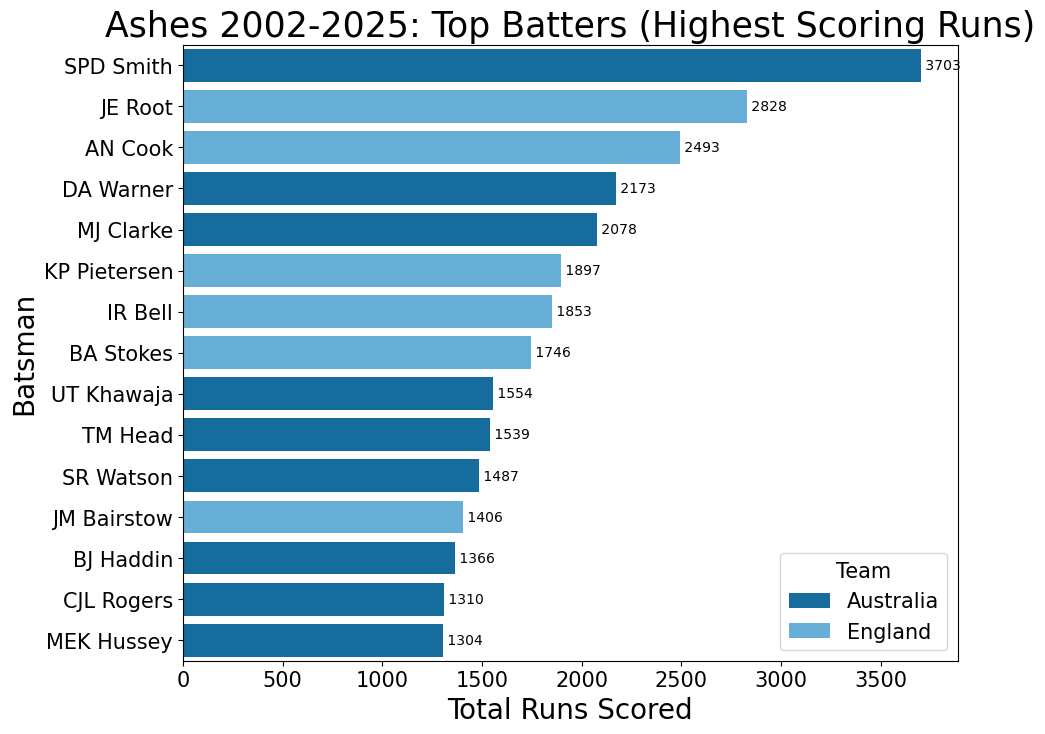

In [9]:
# Creating new dataframe for best batters 
batsman_stats = full_data.groupby(['striker','batting_team'])['runs_off_bat'].sum().reset_index()

# Determinging top 15 batmen
best_batsman = batsman_stats.nlargest(15, 'runs_off_bat')

# Creating barplot of best batters 
plt.figure(figsize = (10,8))
sns.barplot(data = best_batsman, 
            x = 'runs_off_bat', 
            y = 'striker',
            hue = 'batting_team',
            palette = custom_palette)

# Adding number of runs at end of bars 
for index, value in enumerate(best_batsman.runs_off_bat):
    plt.text(value, index, f' {int(value)}', va = 'center')

# Plotting barplot
plt.title('Ashes 2002-2025: Top Batters (Highest Scoring Runs)', fontsize = 25)
plt.xlabel('Total Runs Scored', fontsize = 20)
plt.ylabel('Batsman', fontsize = 20)
plt.legend(title = "Team", loc = 'lower right', title_fontsize = 15, fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

Bar chart showing the top total runs from all matches between 2002-2025, coloured by team of player. Steve Smith has the most runs and Michael Hussey has the least out of the top 15. Joe Root recently took over in the most recent 2025 series.

### Scatter plot showing the top 15 run scorers: strike rate vs batting average

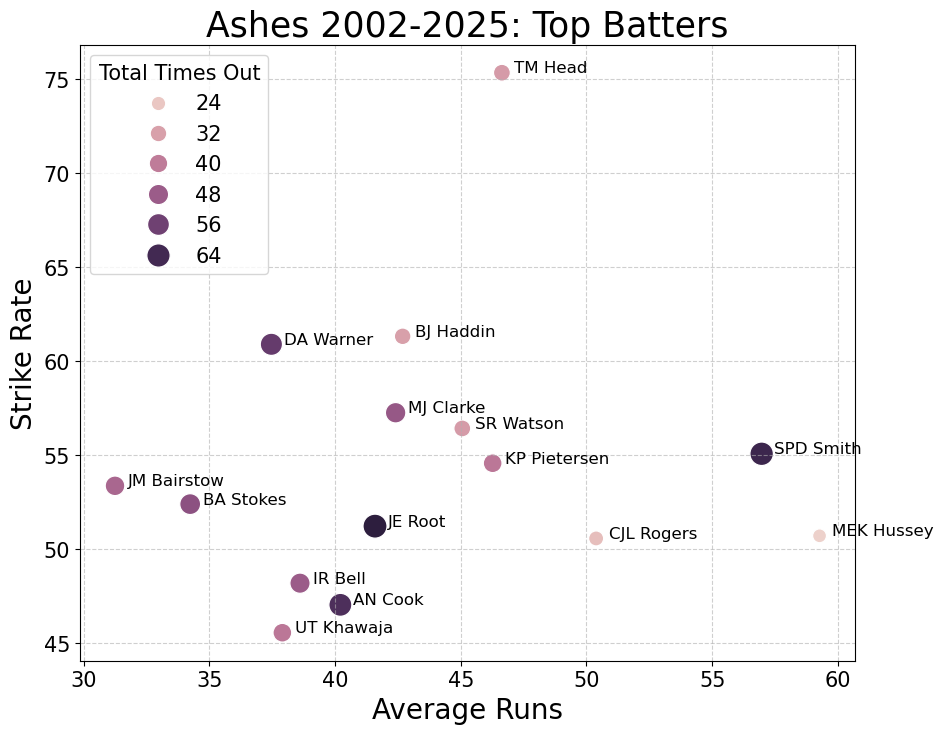

In [10]:
# Find best batting averages
batsman_average = full_data.groupby('striker').agg(total_runs = ('runs_off_bat','sum'), ball_count = ('ball', 'count'), times_out = ('wicket', 'sum')).reset_index()

# New column of strike rate and average 
batsman_average['average'] = batsman_average['total_runs'] / batsman_average['times_out'].replace(0, float('nan'))
batsman_average['strike_rate'] = (batsman_average['total_runs'] / batsman_average['ball_count']*100).replace(0, float('nan'))
batsman_average

top_stats = batsman_average.sort_values(by = 'total_runs', ascending = False)
top_stats

# Top 15 players 
top_players = top_stats.nlargest(15, 'total_runs')

# Plotting scatter plot 
plt.figure(figsize = (10,8))
sns.scatterplot(data = top_players,
                x = 'average',
                y = 'strike_rate',
                size = 'times_out',
                hue = 'times_out',
                sizes = (100,300))

# Adding players names to points
for i in range(top_players.shape[0]):
    plt.text(x = top_players.average.iloc[i] + 0.5,
             y = top_players.strike_rate.iloc[i],
             s = top_players.striker.iloc[i],
             fontsize = 12)

plt.title('Ashes 2002-2025: Top Batters', fontsize = 25)
plt.xlabel('Average Runs', fontsize = 20)
plt.ylabel('Strike Rate', fontsize = 20)
plt.legend(title = "Total Times Out",loc = 'upper left', fontsize = 15, title_fontsize = 15)
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()


Scatter plot coloured and sized by total times dismissed/ out. The higher strike rate and average runs the better. Travis Head by far has the highest strike rate. 

In [11]:
from scipy.stats import pearsonr
# Correlation between batting avg and strike rate
# Convert dataframe into series
l3 = batsman_average['average']
l4 = batsman_average['strike_rate']

# Applying the pearsonr()
corr, _ = pearsonr(l3, l4)
print('Pearsons correlation: %.1f' % corr)
print('Weak Correlation')

Pearsons correlation: nan
Weak Correlation


### Heatmap of top batters in each series 

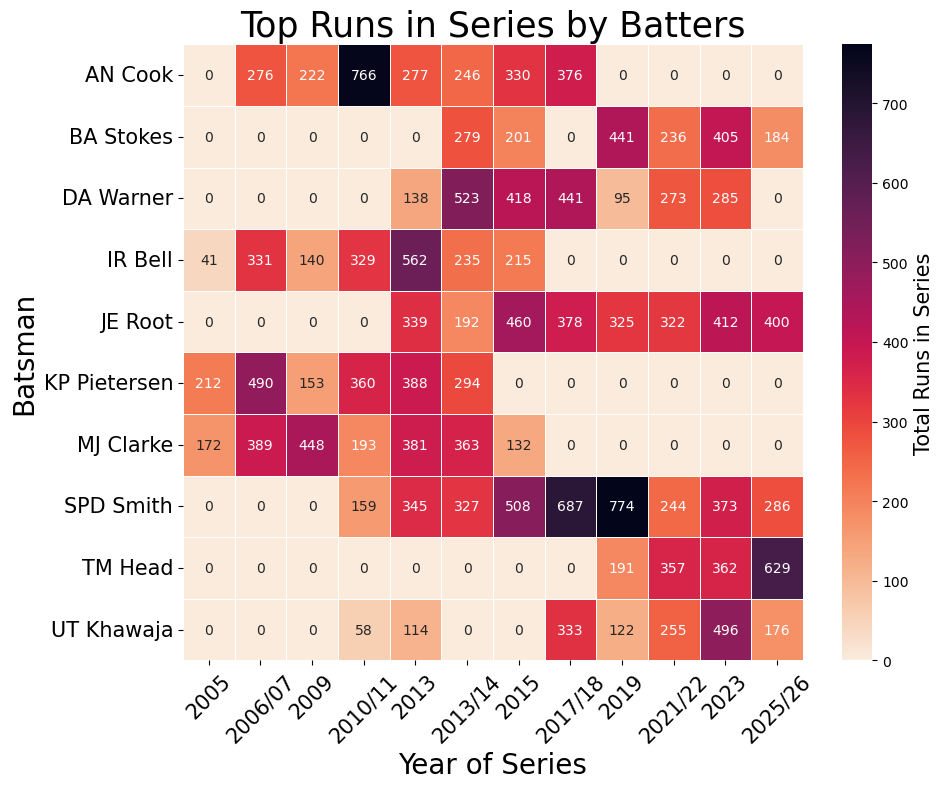

In [12]:
# Creating heatmap to show the top batters in each series 
top_10_names = full_data.groupby('striker')['runs_off_bat'].sum().nlargest(10).index
full_data['season'] = full_data['season'].astype(str).str.strip()

heatmap_batter = full_data[full_data['striker'].isin(top_10_names)].pivot_table(
    index = 'striker',
    columns = 'season',
    values = 'runs_off_bat',
    aggfunc = 'sum').fillna(0)

plt.figure(figsize = (10,8))
ax = sns.heatmap(heatmap_batter,
            annot = True,
            fmt = '.0f',
            cmap = 'rocket_r',
            linewidths = .5,
            cbar_kws = {'label': 'Total Runs in Series'})

# Plotting heatmap
plt.title('Top Runs in Series by Batters', fontsize = 25)
plt.ylabel('Batsman', fontsize = 20)
plt.xlabel('Year of Series', fontsize = 20)
plt.xticks(rotation = 45)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.figure.axes[-1].yaxis.label.set_size(15)

plt.show()

Heatmap showing the top runs scored in each series with Steve Smith having the most runs in the 2019 series. 

### The effect of bazball

What is bazball??

Bazball is the aggressive, fearless style of Test cricket played by the England team under coach Brendon "Baz" McCullum, emphasizing quick scoring, attacking bowlers, and positive decisions to force results, rather than defensive play, a mindset adopted in 2022 that aims for entertainment and dominance by taking risks and maintaining high run rates. 

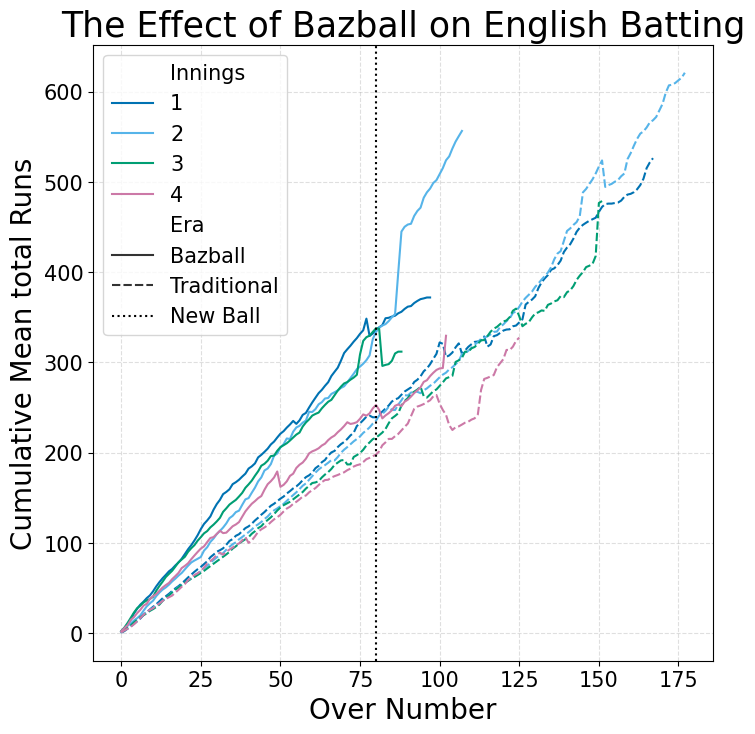

In [13]:
#series_2025 = full_data[(full_data['year'] == 2025) | (full_data['year'] == 2026)]
full_data['era'] = full_data['year'].apply(lambda x: 'Bazball' if x >= 2022 else 'Traditional')
over_runs = full_data.groupby(['innings','over_num', 'batting_team', 'era'])['Runs_added_up'].mean().reset_index()
over_runs.columns = ['Innings', 'Over Number', 'Batting Team', 'Era', 'Total Runs']

# Adding colours 
custom_palette_1 = sns.color_palette(['#0072B2', '#56B4E9', '#009E73', '#CC79A7'])

# Plotting line plot 
plt.figure(figsize = (8,8))
ax = sns.lineplot(data = over_runs[over_runs['Batting Team'] == 'England'], 
             x = "Over Number", 
             y = "Total Runs", 
             hue = "Innings", 
             style = "Era", 
             palette = custom_palette_1)

# Adding a line for when a new ball is distributed at 80 overs 
ax.axvline(80, color = "black", linestyle=":", label = "New Ball")

# Adding titles, changing fontsize
plt.title('The Effect of Bazball on English Batting', fontsize = 25)
plt.xlabel('Over Number', fontsize = 20)
plt.ylabel('Cumulative Mean total Runs', fontsize = 20)
plt.legend(loc = 'upper left', fontsize = 15, title_fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True, linestyle = '--', alpha = 0.4)
plt.show()


This line plot actually shows quite a lot. The dashed line shows the progress of runs throughout an innings before the introduction of bazball and the solid is after the introduction. Each colour represents an innings. Innings 2 has the highest amount of runs as expected. After the introduction of bazball you can see the rate of runs is higher then the traditional, showing the more aggressive style of play. I also added a dotted line for when a new ball is introduced in an innings. The new ball will move around the wicket a lot more leading to a decrease in runs after the line. 

<Axes: xlabel='run_rate', ylabel='Density'>

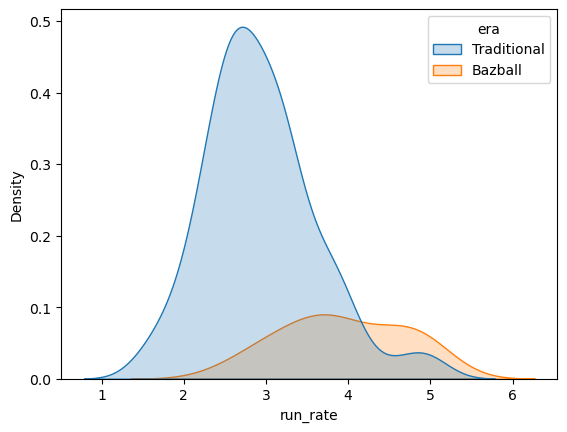

In [14]:
full_data['era'] = full_data['year'].apply(lambda x: 'Bazball' if x >= 2022 else 'Traditional')

# Calculate Team Run Rate per Innings 
innings_stats = full_data.groupby(['match_id', 'innings', 'era','batting_team']).agg({
    'runs_off_bat': 'sum',
    'ball': 'count'
}).reset_index()
innings_stats['run_rate'] = (innings_stats['runs_off_bat'] / innings_stats['ball']) * 6

# Plot the difference
sns.kdeplot(data = innings_stats[innings_stats['batting_team'] == 'England'], 
            x = 'run_rate', hue = 'era', fill = True)

### Strike rate vs over number, how does scoring rate change as an innings progresses?

Correlation:  0.461
P-value:  1.518e-11


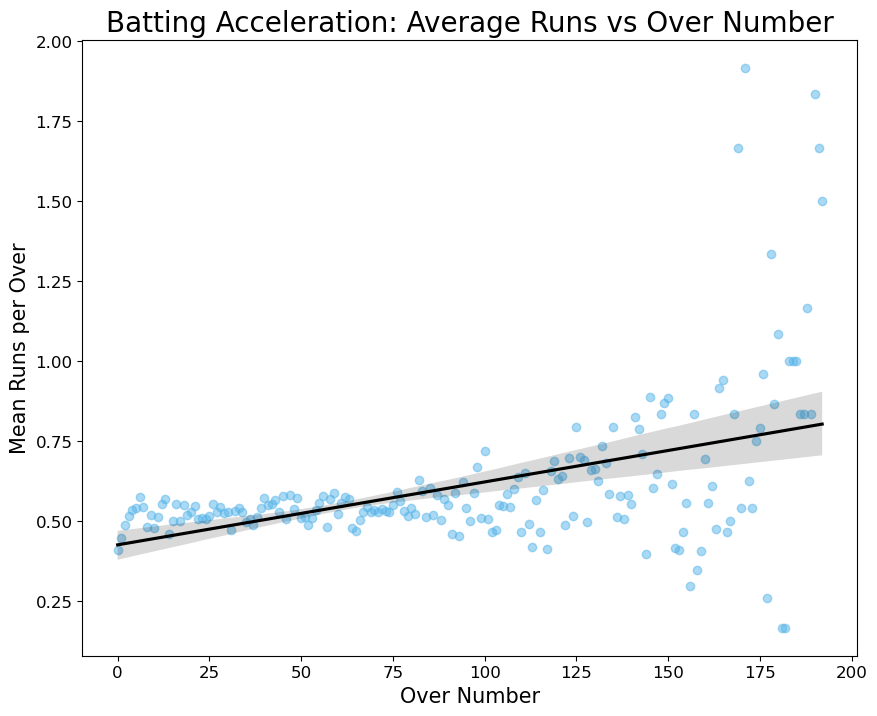

In [15]:
import scipy.stats as stats

# Creating dataframe of over numbers and the average run from that over 
over_stats = full_data.groupby('over_num')['runs_off_bat'].mean().reset_index()
over_stats.columns = ['Over', 'Average_runs']

# Performing pearson correlation test
correlation, p_value = stats.pearsonr(over_stats['Over'], over_stats['Average_runs'])
print(f"Correlation: {correlation: .3f}")
print(f"P-value: {p_value: .3e}")

# Plotting mean runs per ball vs over number with line of best fit 
plt.figure(figsize = (10,8))
sns.regplot(data = over_stats, 
            x = 'Over',
            y = 'Average_runs',
            scatter_kws = {'alpha': 0.5},
            line_kws = {'color': 'black'},
            color = '#56B4E9')
plt.title('Batting Acceleration: Average Runs vs Over Number', fontsize = 20)
plt.xlabel('Over Number', fontsize = 15)
plt.ylabel('Mean Runs per Over', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

This scatter plot shows the mean runs per over against the over number. Shows that as an innings progresses the general trend in mean runs increases slightly. At the end of an innings the mean number of runs seems to either increase or decrease. 

Plot improvement: colour by innings and batting team 

## Match and series results

### Bar chart showing the results of matches between 2002 and 2025 (excludes first 3 matches in 2002/03 series and last 3 matches in 2005 series)

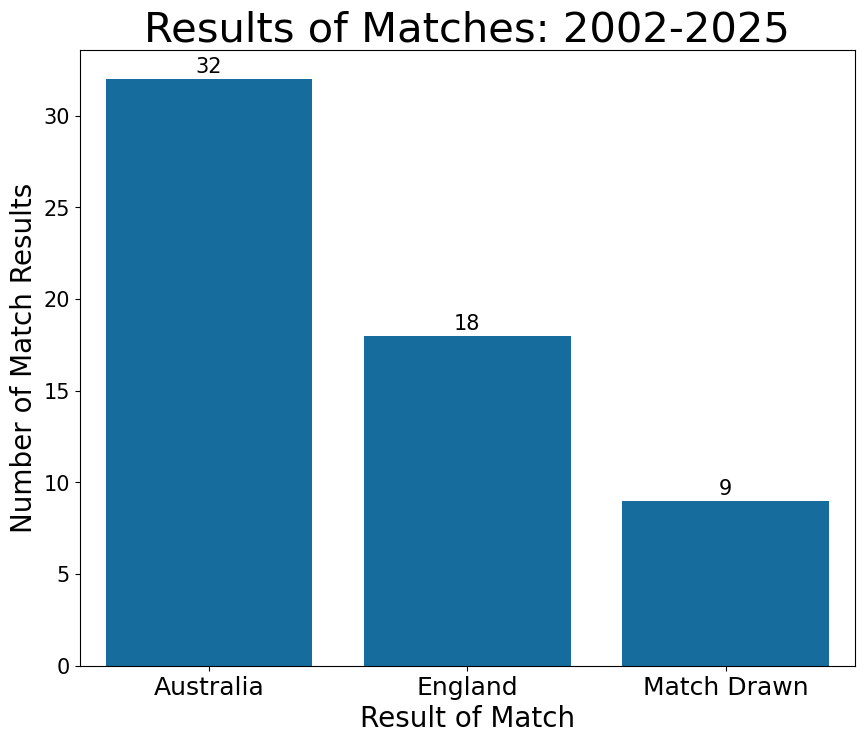

In [16]:
# Determining winner of match or if match drawn
match_scores = full_data.groupby(['match_id', 'batting_team'])['total_scored'].first().unstack()

# indicating which matches between 2002-2025 were a draw
def get_match_winner(row):
    # Matches that have been drawn 
    draw_ids = [1152847, 1336046, 345970, 345972, 428749, 566934, 566936, 1072308, 1263465]

    if row.name in draw_ids:
        return 'Match Drawn'
    if row['England'] > row['Australia']:
        return 'England'
    if row['Australia'] > row['England']:
        return 'Australia'
    else:
        return 'Match Drawn'
# Appling loop
match_results = match_scores.apply(get_match_winner, axis = 1)

# Plotting who won which ashes matches
plt.figure(figsize = (10,8))
results_match = match_results.reset_index(name = 'Result of Match')
ax = sns.countplot(results_match, x = "Result of Match", color = '#0072B2')

# Adding numbers to top of bars 
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0,9),
                    textcoords = 'offset points',
                    fontsize = 15)

plt.title("Results of Matches: 2002-2025", fontsize = 30)
plt.ylabel("Number of Match Results", fontsize = 20)
plt.xlabel("Result of Match", fontsize = 20)
plt.xticks(ha = 'center')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 15)
plt.show()

In [17]:
# Determinning the result of each series 
# New dataframe of match_id, season and winner of match 
series_results = full_data[['match_id', 'season']].drop_duplicates().set_index('match_id')
series_results['winner'] = match_results

# Creating series winner column
series_counts = series_results.groupby(['season', 'winner']).size().unstack(fill_value = 0)
def determine_series_outcome(row):
    eng_wins = row.get('England', 0)
    aus_wins = row.get('Australia', 0)
    
    if eng_wins > aus_wins:
        return 'England'
    elif aus_wins > eng_wins:
        return 'Australia'
    else:
        return 'Series Drawn'

# Applying loop
series_final = series_counts.apply(determine_series_outcome, axis = 1)
series_summary = series_final.to_frame(name = 'Result').reset_index()

match_info = full_data.groupby(['season','match_id']).agg({'venue': 'first'}).reset_index()

# Creating series to show if home or away game 
venue_country = {'Melbourne Cricket Ground': 'Australia', 
                 'Sydney Cricket Ground': 'Australia',
                 'Brisbane Cricket Ground, Woolloongabba': 'Australia',
                 'Adelaide Oval': 'Australia',
                 'W.A.C.A. Ground': 'Australia',
                 'Sophia Gardens': 'England',
                 'Lord\'s': 'England',
                 'Edgbaston': 'England',
                 'Headingley': 'England',
                 'Kennington Oval': 'England',
                 'Western Australia Cricket Association Ground': 'Australia',
                 'Trent Bridge': 'England',
                 'Old Trafford': 'England',
                 'Brisbane Cricket Ground, Woolloongabba, Brisbane': 'Australia',
                 'Riverside Ground': 'England',
                 'Edgbaston, Birmingham': 'England',
                 'Bellerive Oval, Hobart': 'Australia',
                 'Lord\'s, London': 'England',
                 'Headingley, Leeds': 'England',
                 'Old Trafford, Manchester': 'England',
                 'Kennington Oval, London': 'England',
                 'Perth Stadium': 'Australia'}

# New column for which country hosted
match_info['host_country'] = match_info['venue'].map(venue_country).fillna('Other')
match_info = match_info.groupby('season')['host_country'].first().reset_index()

# Merging two dataframes
final_df = pd.merge(series_summary, match_info, on = 'season')
final_df.loc[final_df['season'] == '2002/03', 'Result'] = 'Australia'
final_df.loc[final_df['season'] == '2005', 'Result'] = 'England'

print(final_df)
# Result for 2002/2003 and 2005 is wrong (australia win 2002 and england win 2005) however I don't have all the matches for these series 

     season        Result host_country
0   2002/03     Australia    Australia
1      2005       England      England
2   2006/07     Australia    Australia
3      2009       England      England
4   2010/11       England    Australia
5      2013       England      England
6   2013/14     Australia    Australia
7      2015       England      England
8   2017/18     Australia    Australia
9      2019  Series Drawn      England
10  2021/22     Australia    Australia
11     2023  Series Drawn      England
12  2025/26     Australia    Australia


### Bar chart showing the results of series 

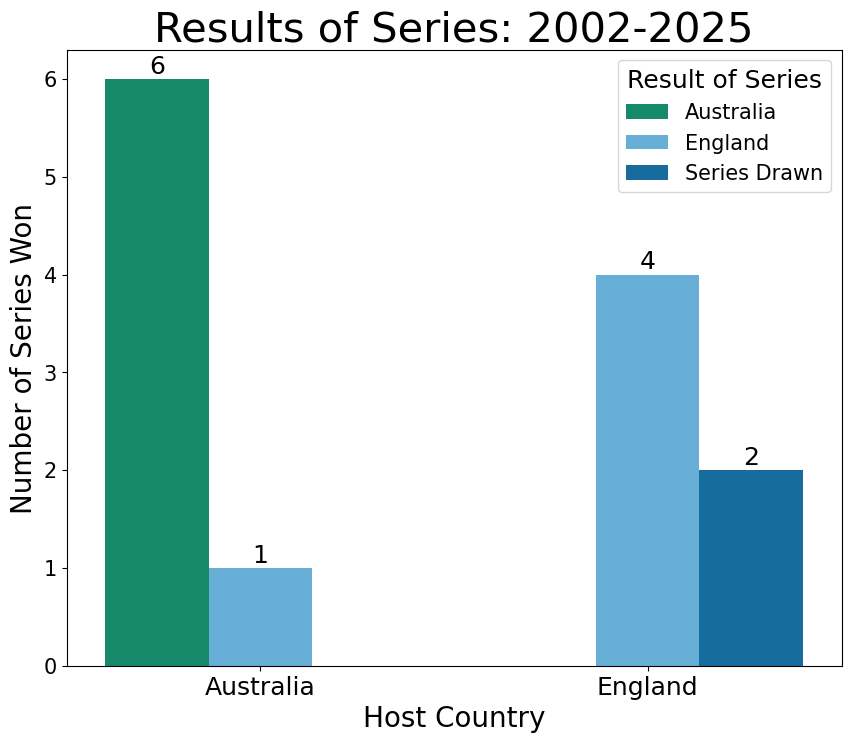

In [18]:
# Plotting who won which ashes series
# Need to remove 2002/2003 AND 2005
custom_palette = {
    'Series Drawn': '#0072B2',
    'Australia': '#009E73', 
    'England': '#56B4E9'   
}

#hue_order = ['Australia','Series Drawn', 'England' ]

plt.figure(figsize = (10,8))
ax = sns.countplot(final_df, x = "host_country", hue = "Result", palette = custom_palette)

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0,9),
                    textcoords = 'offset points',
                    fontsize = 18)

        
plt.title("Results of Series: 2002-2025", fontsize = 30)
plt.ylabel("Number of Series Won", fontsize = 20)
plt.xlabel("Host Country", fontsize = 20)
plt.legend(title = "Result of Series", loc = 'upper right', title_fontsize = 18, fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 15)

plt.show()

## Investigating Home advantage

In [19]:
# Adding host country as a column 
full_data['host_country'] = full_data['venue'].map(venue_country).fillna('Other')

# Determing whether batting team is home or away 
def get_venue(row):
    if row['batting_team'] == row['host_country']:
        return 'Home'
    else:
        return 'Away'

# Adding if its an australian or english venue to full dataset 
full_data['venue_status'] = full_data.apply(get_venue, axis = 1)

# Creating new dataframe of home and away matches 
home_away = full_data.groupby(['match_id', 'venue_status','batting_team', 'host_country','match_label'])['total_runs'].sum().reset_index()
home_match = home_away[home_away['venue_status'] == 'Home'][['match_id','batting_team', 'host_country','total_runs', 'match_label']]
home_match = home_match.set_index('match_id')

# Adding winner column
home_match['winner'] = match_results
home_match = home_match.reset_index()

# Calculating win count 
home_match['home_win'] = home_match.apply(lambda x: x['batting_team'] in x['winner'], axis = 1)
win_count = home_match['home_win'].value_counts(normalize = True) * 100
win_count


home_win
True     62.711864
False    37.288136
Name: proportion, dtype: float64

### Bar chart showing the percentage of matches won at home vs away/drawn

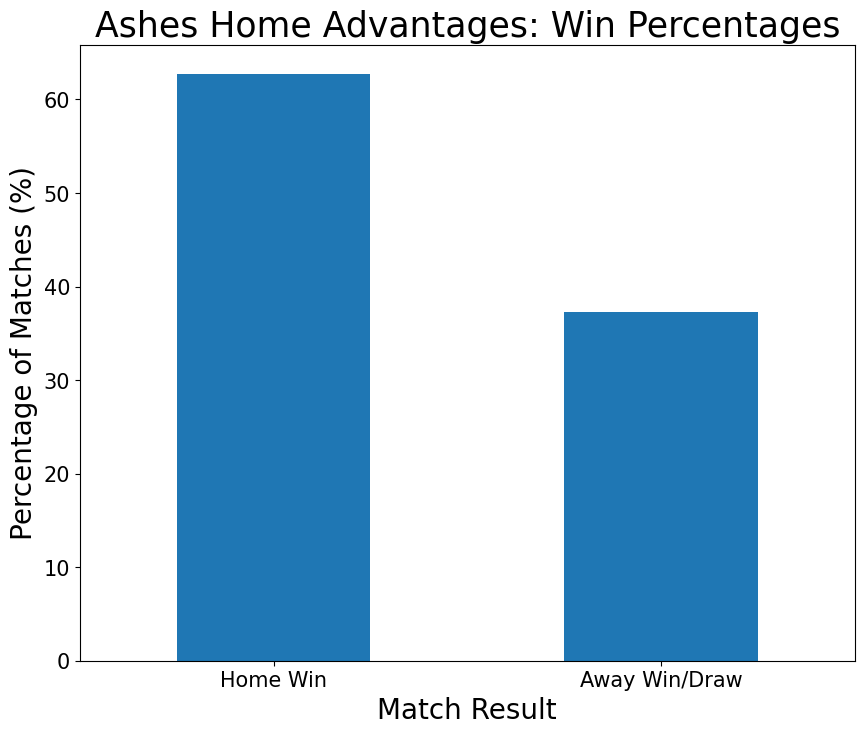

In [20]:
# Plotting percentage of wins at home and away 
plt.figure(figsize = (10,8))
win_count.plot(kind = 'bar')

plt.title('Ashes Home Advantages: Win Percentages',  fontsize = 25)
plt.xticks([0,1], ['Home Win','Away Win/Draw'], rotation = 0)
plt.xlabel('Match Result',  fontsize = 20)
plt.ylabel('Percentage of Matches (%)',  fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()


Hypothetically the ratio of winning at home vs away should be 50:50. In actual fact from looking at the matches from the Ashes series it's 62:38.

In [21]:
from scipy import stats
# Statistical analysis by binominal test from scipy

home_wins = home_match['home_win'].sum()
total_matches = len(home_match)

p_value = stats.binomtest(home_wins, n = total_matches, p = 0.5, alternative = 'greater')

print(f"Home Win Rate: {(home_wins/total_matches)*100: .2f}%")
print(f"P-Value: {p_value.pvalue:.4f}")

if p_value.pvalue < 0.05:
    print("Result is Statistically Significant. There is a home advantage.")
else:
    print("Result is Not Statistically Significant.")


Home Win Rate:  62.71%
P-Value: 0.0337
Result is Statistically Significant. There is a home advantage.


### Boxplot of distribution of match runs 

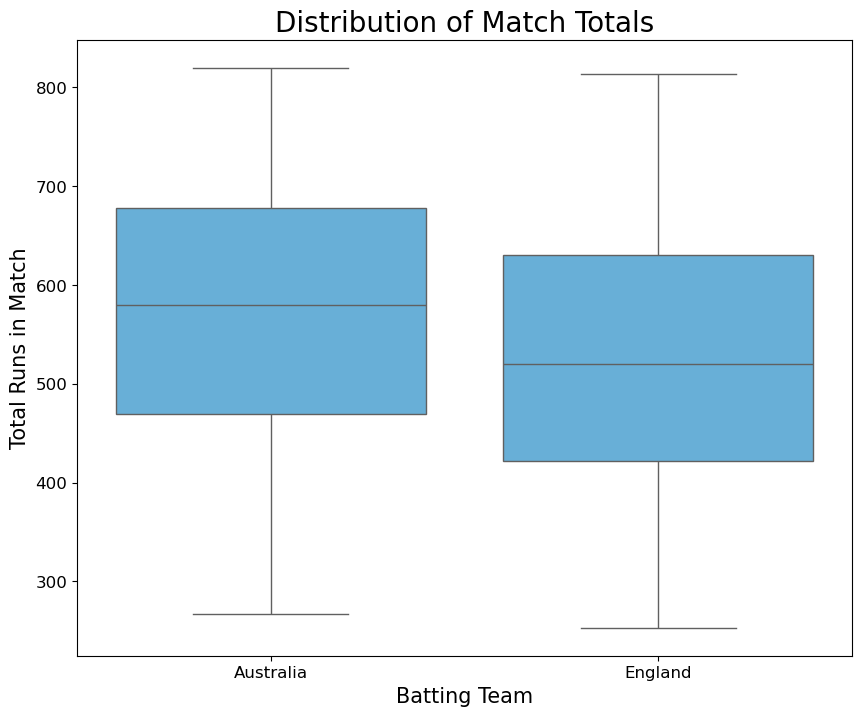

In [22]:
match_summaries = full_data.drop_duplicates(subset = ['match_id', 'batting_team'])

# Box plot of total runs between australia and england 
plt.figure(figsize = (10,8))
sns.boxplot(data = match_summaries[match_summaries['batting_team'].isin(['Australia', 'England'])], 
            x = 'batting_team',
            y = 'total_scored',
            color = '#56B4E9')
plt.title('Distribution of Match Totals', fontsize = 20)
plt.ylabel('Total Runs in Match', fontsize = 15)
plt.xlabel('Batting Team', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

Australia on average score more runs then england in a match!!

## Head to head rivalries 

In [23]:
# Creating dataset of wickets only that aren't run outs
wickets_only = full_data.dropna(subset = ['wicket_type']).copy()
wickets_only = wickets_only[wickets_only['wicket_type'] != 'run out']
wickets_only = wickets_only[~wickets_only['player_dismissed'].isin(['nan', 'none', '0', 'none', 'nan'])]

In [24]:
# Determining the top 10 batters and bowlers from wickets only dataset with most wickets
top_bowlers = wickets_only['bowler'].value_counts().nlargest(10).index
top_batsmen = wickets_only['player_dismissed'].value_counts().nlargest(10).index

# Merging dataframe 
h2h_data = wickets_only[
    (wickets_only['bowler'].isin(top_bowlers)) & 
    (wickets_only['player_dismissed'].isin(top_batsmen))]


### Heatmap showing head to head rivalies, coloured by number of dismissals 

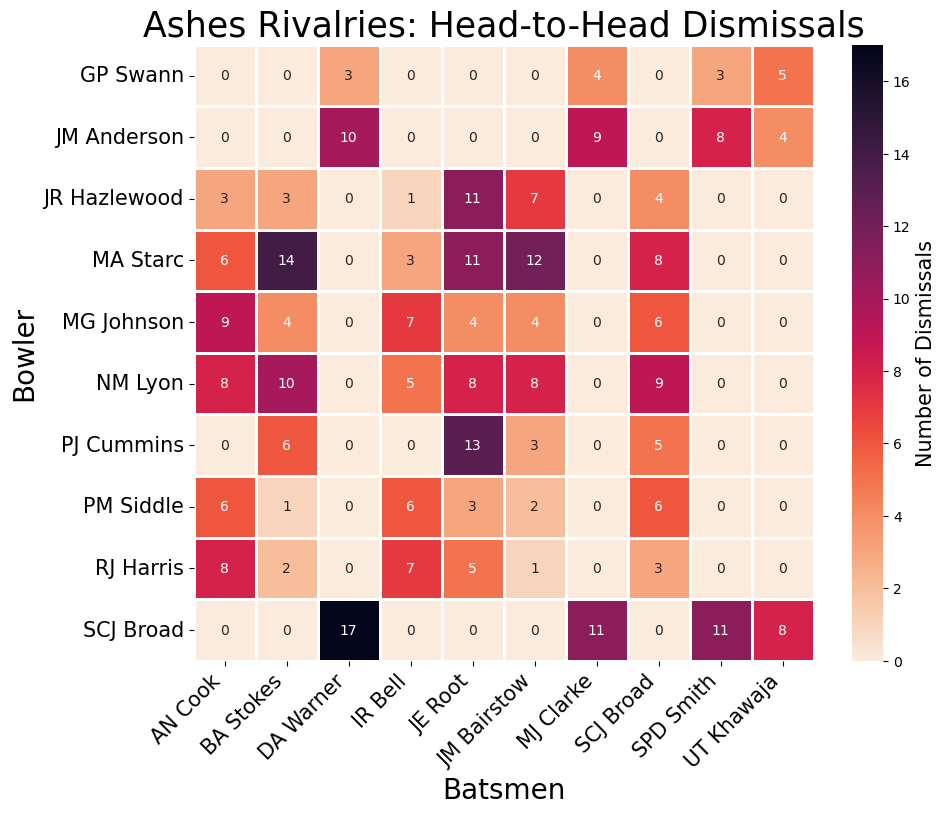

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating heatmap to show the top rivalrives and number of wickets in those rivalries
heatmap_matrix = h2h_data.groupby(['bowler','player_dismissed']).size().unstack(fill_value = 0).dropna()

plt.figure(figsize = (10,8))

#mask = heatmap_matrix == 0

ax = sns.heatmap(heatmap_matrix, 
            annot = True, 
            fmt = 'd', 
            cmap = 'rocket_r', 
            linewidths = 1, 
            linecolor = 'white', 
            cbar_kws = {'label': 'Number of Dismissals'})

plt.title("Ashes Rivalries: Head-to-Head Dismissals", fontsize = 25)
plt.ylabel("Bowler", fontsize = 20)
plt.xlabel("Batsmen", fontsize = 20)
plt.xticks(rotation = 45, ha = 'right')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.figure.axes[-1].yaxis.label.set_size(15)
plt.show()

### Bar chart of batters dissmissals by bowler and line plot how many runs they scored against that bowler

         bowler player_dismissed  number_runs_against_bowler  dismissals
675   SCJ Broad        DA Warner                         289          17
369    MA Starc        BA Stokes                         266          14
591  PJ Cummins          JE Root                         312          13
385    MA Starc      JM Bairstow                         449          12
627   PM Siddle         MJ Prior                         354          12


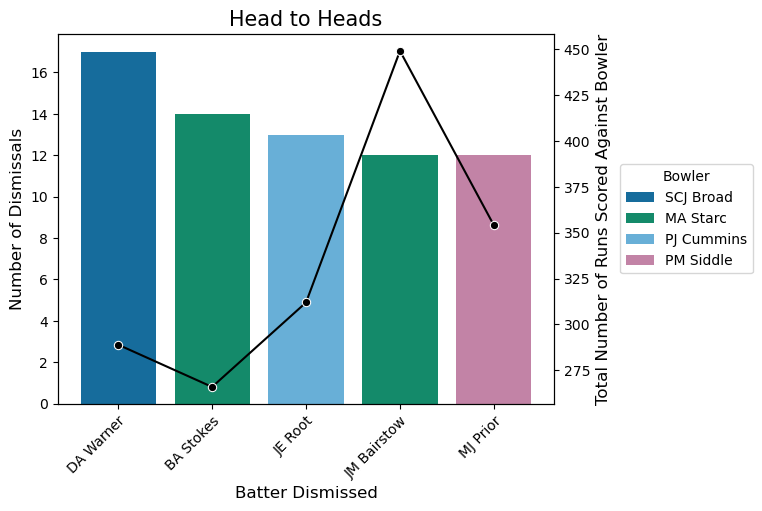

In [26]:
# New data set without run outs 
dismissals = full_data[full_data['wicket'] == 1 & (full_data['wicket_type'] != 'run out')]
dismissals = dismissals[["match_id", "season", "venue", "innings", "ball", "batting_team", "bowler", "wicket_type", "player_dismissed", "over_num", "ball_num", "player_match_runs", "total_scored"]]

# Summing runs against the bowler from batter
dismissals['number_runs_against_bowler'] = dismissals.groupby(['bowler','player_dismissed'])['player_match_runs'].transform('sum')

# Determing top number of dismissals 
h2h = dismissals.groupby(['bowler', 'player_dismissed','number_runs_against_bowler']).size().reset_index(name='dismissals')
top_owners = h2h.sort_values(by='dismissals', ascending = False).head(5)
#top_owners['matchup'] = top_owners['player_dismissed']+ "(vs" + top_owners['bowler']+")"

# Custom palette of colour blind friendly colours 
custom_palette = {
    'SCJ Broad': '#0072B2',
    'MA Starc': '#009E73', 
    'PJ Cummins': '#56B4E9',
    'PM Siddle': '#CC79A7',
    'JM Anderson': "#D55E00",
    'JR Haxlewood': "#999999"
}

# Creating barplot
fig, ax1 = plt.subplots()
ax1 = sns.barplot(top_owners,
                  x = "player_dismissed",
                  y = "dismissals",
                  hue = "bowler",
                  palette = custom_palette,
                  dodge = False, ax = ax1)

plt.legend(title = "Bowler",loc = 'center left', bbox_to_anchor = (1.12, 0.5))
plt.title("Head to Heads", fontsize = 15)
plt.xticks(rotation = 45, ha = "right", rotation_mode = "anchor")
ax1.set_ylabel("Number of Dismissals", fontsize = 12)
ax1.set_xlabel("Batter Dismissed", fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
ax1.grid(False)

# Creating lineplot 
ax2 = ax1.twinx()
sns.lineplot(top_owners,
             x = 'player_dismissed', 
             y = 'number_runs_against_bowler', 
             ax = ax2, 
             color = 'black', 
             marker = 'o', 
             sort = False,
             errorbar = None)
ax2.set_ylabel('Total Number of Runs Scored Against Bowler', fontsize = 12)
ax2.grid(False)
print(top_owners)

## Wicket Distribution and Probability 

### Percentages of types of dismissals from matches from 2002 to 2025

      Dismissal type  Value
0             caught   1277
1             bowled    335
2                lbw    265
3            run out     40
4  caught and bowled     35
5            stumped     17
6         hit wicket      2
7       retired hurt      2


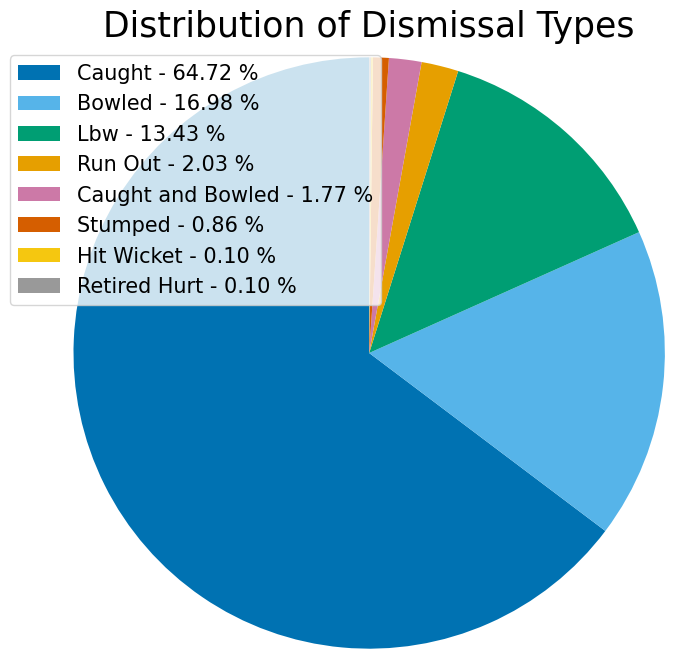

In [27]:
import numpy as np
# Dataframe counting number of each wicket type in all matches 
all_dismissals = full_data[full_data['wicket_type'] != 'none']
dismissal_count = all_dismissals['wicket_type'].value_counts().reset_index()
dismissal_count.columns = ['Dismissal type', 'Value']
print(dismissal_count)

my_colours = ["#0072B2","#56B4E9","#009E73",  "#E69F00", "#CC79A7",   "#D55E00", "#F5C710","#999999", "#000000"]

# Calculating percentages of wickets 
x = np.char.array(['Caught','Bowled','Lbw','Run Out','Caught and Bowled','Stumped','Hit Wicket','Retired Hurt'])
y = np.array([1277, 335, 265, 40, 35, 17, 2, 2])
porcent = 100.*y/y.sum()

# Plotting pie chart
plt.figure(figsize = (8,8))
patches, texts = plt.pie(y, startangle = 90, radius = 1.2, colors = my_colours)

# Adding label
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key = lambda x: x[2],
                                          reverse = True))

plt.legend(patches, labels, loc = 'upper left', bbox_to_anchor = (-0.1, 1.), fontsize = 15)
plt.title("Distribution of Dismissal Types", fontsize = 25)

plt.show()

### Heatmap looking at the mean number of wickets in a phase of overs in each innings. Wickets in dataframe are either 1 (indicating a wicket) or 0 (no wicket) therefore mean is between 0 and 1- the higher to 1 the more wickets

Chi-Square P-Value for Wicket Distribution:  4.517e-04


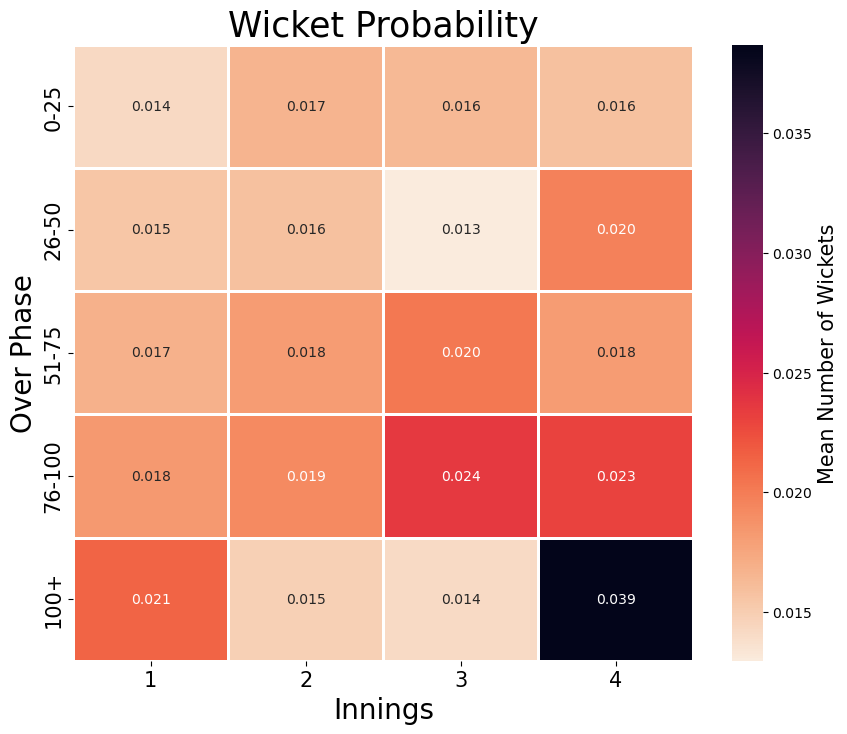

In [28]:
# Creating new column of over phases 
full_data['over_phase'] = pd.cut(full_data['over_num'], bins = [0, 25, 50, 75, 100, 200],
                                 labels = ['0-25', '26-50', '51-75', '76-100', '100+'])
# Summarising data in pivot table 
wicket_pivot = full_data.pivot_table(index = 'over_phase', columns = 'innings', values = 'wicket', aggfunc = 'mean', observed = True)

# Determing chi squared statistic 
contingency_table = pd.crosstab(full_data['over_phase'], full_data['wicket'])
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f"Chi-Square P-Value for Wicket Distribution: {p: .3e}")

# Plotting heatmap
plt.figure(figsize = (10,8))
ax = sns.heatmap(wicket_pivot, 
            annot = True, 
            cmap = 'rocket_r', 
            fmt = '.3f',
            linewidths = 1, 
            linecolor = 'white', 
            cbar_kws = {'label': 'Mean Number of Wickets'})

plt.title("Wicket Probability", fontsize = 25)
plt.ylabel("Over Phase", fontsize = 20)
plt.xlabel("Innings", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.figure.axes[-1].yaxis.label.set_size(15)
plt.show() 


A new ball is offered after every 80 overs!!

In [29]:
series_2025 = full_data[(full_data['year'] == 2025) | (full_data['year'] == 2026)]
series_2025

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,ball_num,player_match_runs,run_totals,total_scored,match_label,bowler_runs,era,host_country,venue_status,over_phase
105413,1455611,2025/26,2025-11-21,Perth Stadium,1,0.1,England,Australia,Z Crawley,BM Duckett,...,1.0,0,172,336,2025(ID: 1455611),0.0,Bazball,Australia,Away,NaN
105414,1455611,2025/26,2025-11-21,Perth Stadium,1,0.2,England,Australia,Z Crawley,BM Duckett,...,2.0,0,172,336,2025(ID: 1455611),0.0,Bazball,Australia,Away,NaN
105415,1455611,2025/26,2025-11-21,Perth Stadium,1,0.3,England,Australia,Z Crawley,BM Duckett,...,3.0,0,172,336,2025(ID: 1455611),0.0,Bazball,Australia,Away,NaN
105416,1455611,2025/26,2025-11-21,Perth Stadium,1,0.4,England,Australia,Z Crawley,BM Duckett,...,4.0,0,172,336,2025(ID: 1455611),0.0,Bazball,Australia,Away,NaN
105417,1455611,2025/26,2025-11-21,Perth Stadium,1,0.5,England,Australia,Z Crawley,BM Duckett,...,5.0,0,172,336,2025(ID: 1455611),0.0,Bazball,Australia,Away,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113164,1455615,2025/26,2026-01-04,Sydney Cricket Ground,4,30.4,Australia,England,C Green,AT Carey,...,4.0,22,161,728,2026(ID: 1455615),4.0,Bazball,Australia,Home,26-50
113165,1455615,2025/26,2026-01-04,Sydney Cricket Ground,4,30.5,Australia,England,C Green,AT Carey,...,5.0,22,161,728,2026(ID: 1455615),0.0,Bazball,Australia,Home,26-50
113166,1455615,2025/26,2026-01-04,Sydney Cricket Ground,4,30.6,Australia,England,C Green,AT Carey,...,6.0,22,161,728,2026(ID: 1455615),4.0,Bazball,Australia,Home,26-50
113167,1455615,2025/26,2026-01-04,Sydney Cricket Ground,4,31.1,Australia,England,AT Carey,C Green,...,1.0,16,161,728,2026(ID: 1455615),0.0,Bazball,Australia,Home,26-50


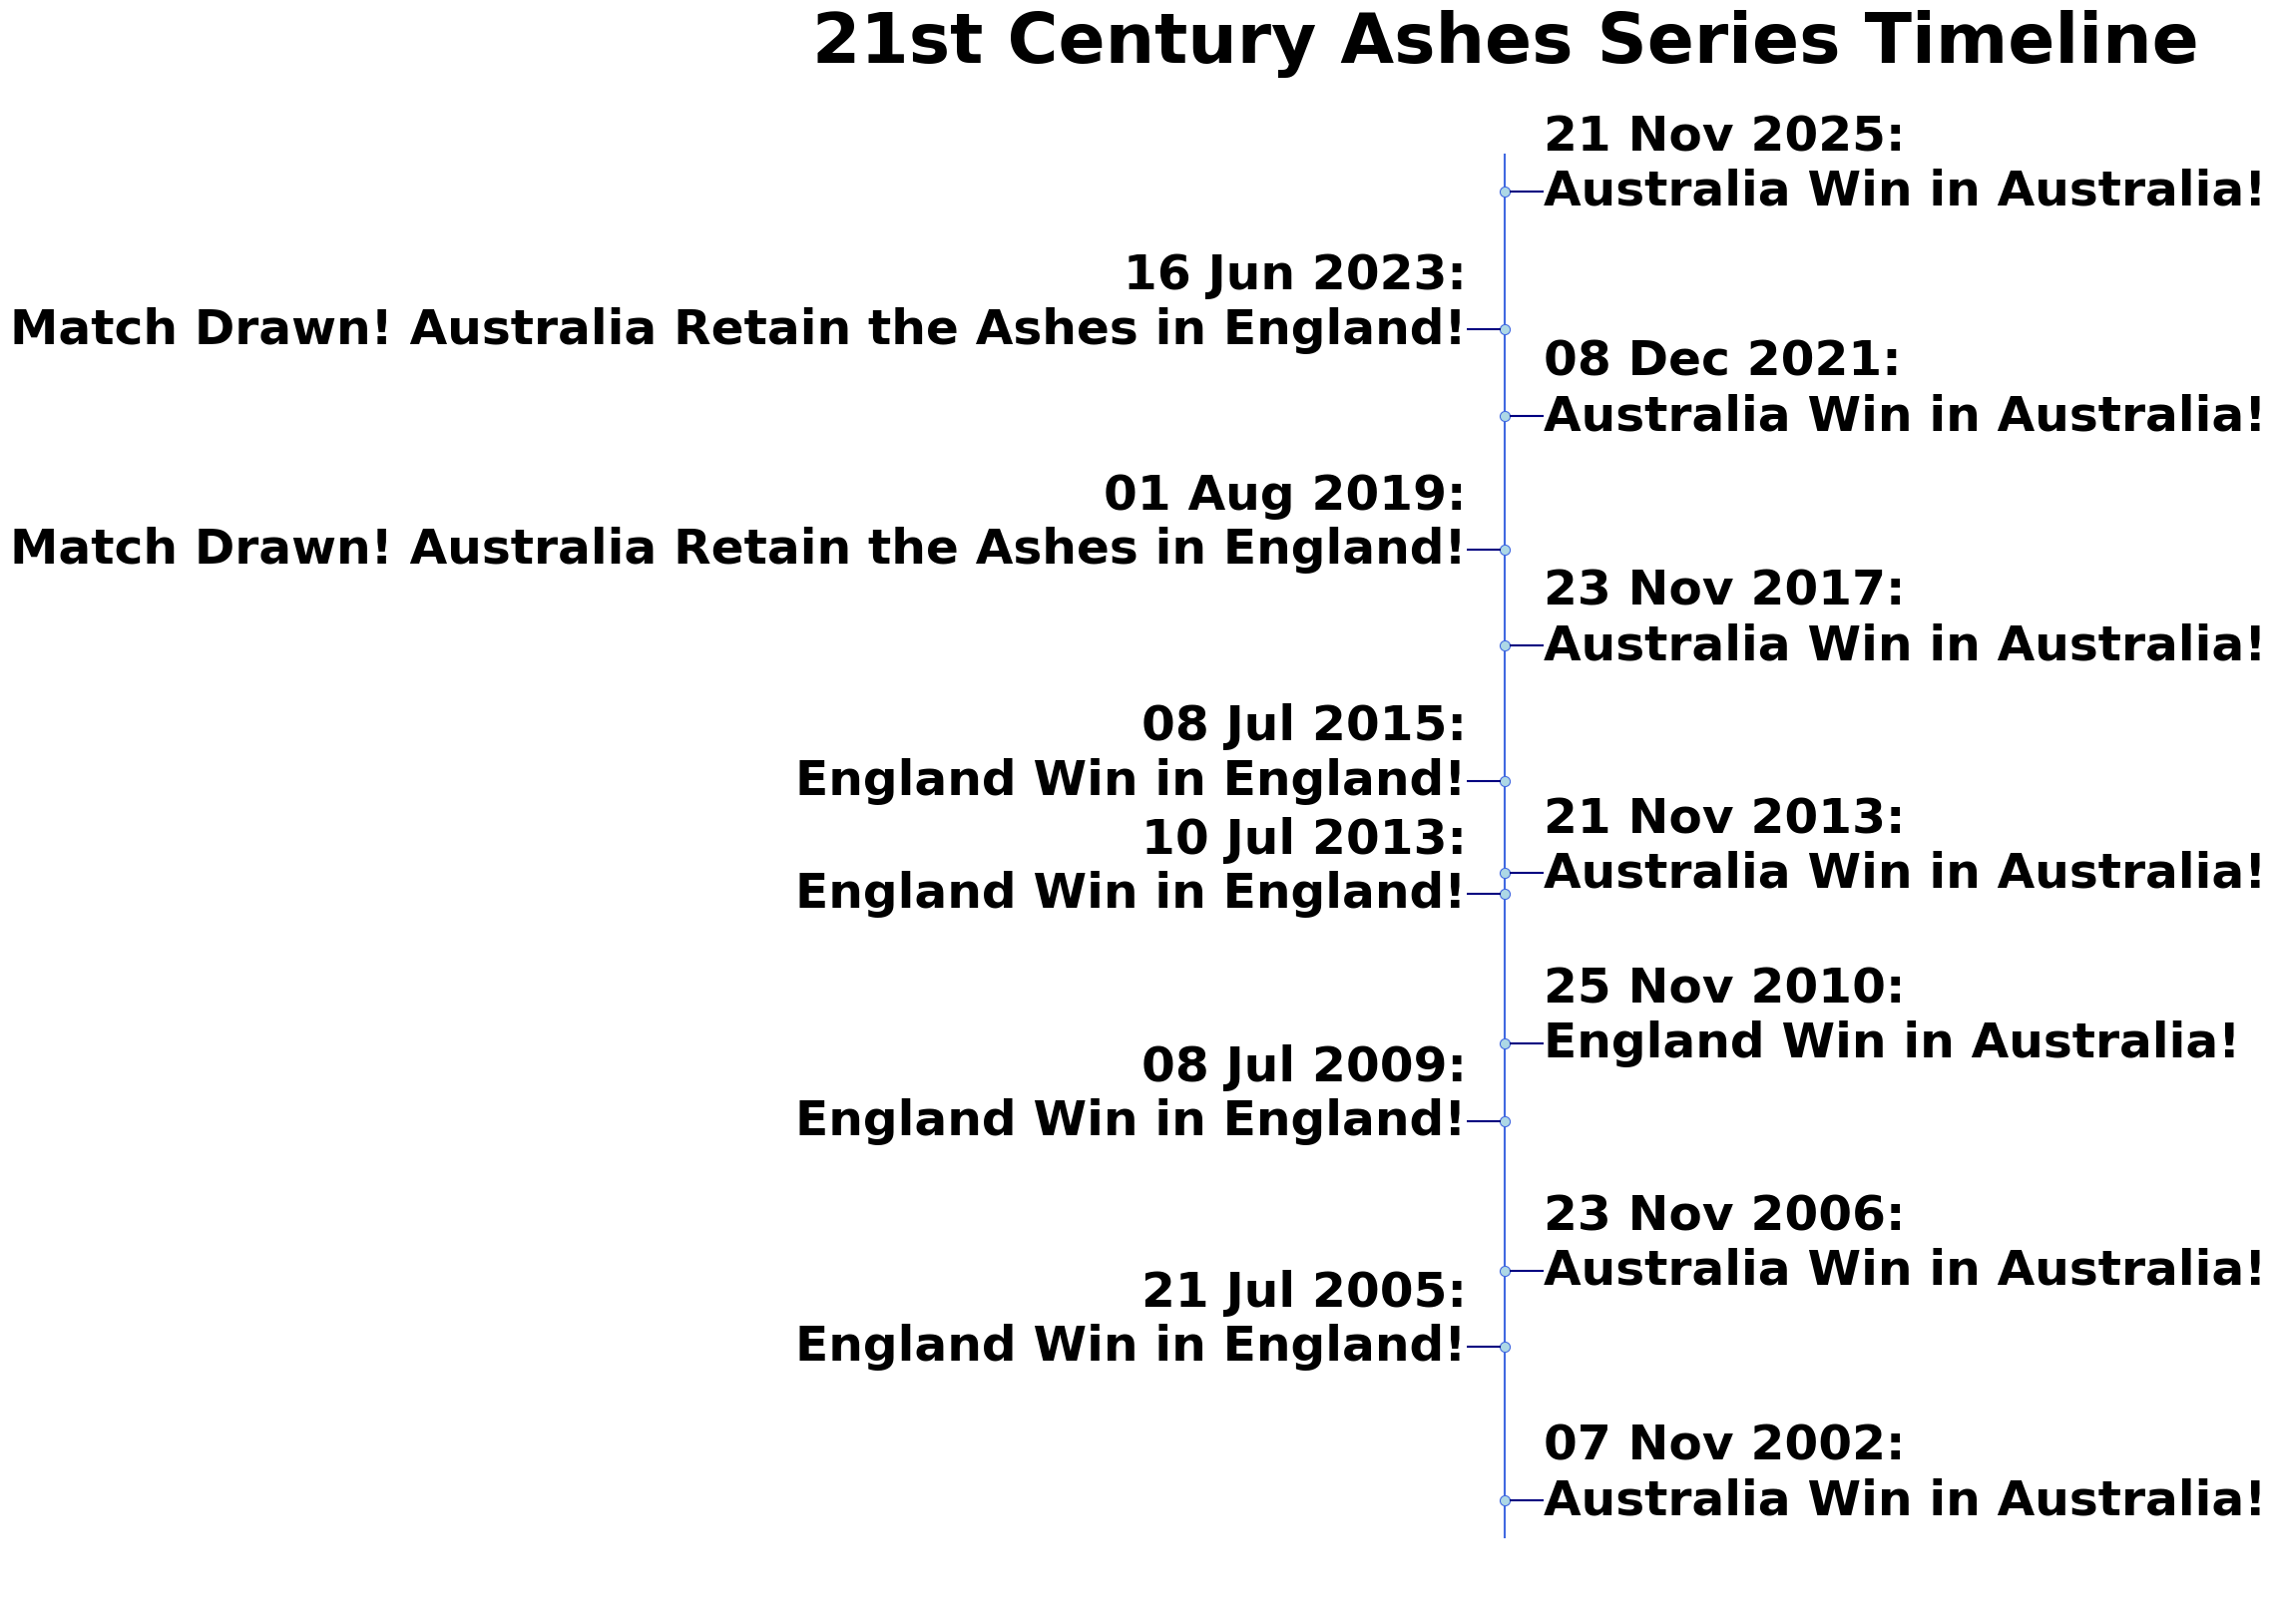

In [31]:
# Importing packages 
from datetime import date 
from datetime import timedelta
%matplotlib inline

# Selecting dates 
dates = [date(2002, 11, 7), 
         date(2005, 7, 21), 
         date(2006, 11, 23), 
         date(2009, 7, 8), 
         date(2010, 11, 25),
         date(2013, 7, 10),
         date(2013, 11, 21),
         date(2015, 7, 8),
         date(2017, 11, 23),
         date(2019, 8, 1),
         date(2021, 12, 8),
         date(2023, 6, 16),
         date(2025, 11, 21)]

# adding min and max dates
min_date = date(np.min(dates).year - 2, np.min(dates).month, np.min(dates).day)
max_date = date(np.max(dates).year + 2, np.max(dates).month, np.max(dates).day)

# creating labels 
labels = ['Australia Win in Australia!',
          'England Win in England!',
          'Australia Win in Australia!',
          'England Win in England!',
          'England Win in Australia!',
          'England Win in England!',
          'Australia Win in Australia!',
          'England Win in England!',
          'Australia Win in Australia!',
          'Match Drawn! Australia Retain the Ashes in England!',
          'Australia Win in Australia!',
          'Match Drawn! Australia Retain the Ashes in England!',
          'Australia Win in Australia!']

labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]

# Plotting time series 
fig, ax = plt.subplots(figsize = (10, 20), constrained_layout = False)
_ = ax.set_xlim(-20, 20)
_ = ax.set_ylim(min_date, max_date)
_ = ax.axvline(0, ymin = 0.05, ymax = 0.95, c = 'royalblue', zorder = 1)
 
_ = ax.scatter(np.zeros(len(dates)), dates, s = 50, c = 'royalblue', zorder = 2)
_ = ax.scatter(np.zeros(len(dates)), dates, s = 30, c = 'lightblue', zorder = 3)

label_offsets = np.repeat(2.0, len(dates))
label_offsets[1::2] = -2.0
for i, (l, d) in enumerate(zip(labels, dates)):
    d = d - timedelta(days=90)
    align = 'right'
    if i % 2 == 0:
        align = 'left'
    _ = ax.text(label_offsets[i], d, l, ha = align, fontweight = 'bold', color = 'black',fontsize = 35)


stems = np.repeat(2.0, len(dates))
stems[1::2] *= -1.0   
x = ax.hlines(dates, 0, stems, color = 'navy')

# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax.spines[spine].set_visible(False)
 
# hide tick labels
_ = ax.set_xticks([])
_ = ax.set_yticks([])
 
_ = ax.set_title('21st Century Ashes Series Timeline', fontweight = "bold", fontsize = 50, 
                 color = 'black')



